In [1]:
import os
gpu_num = 0 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
# Import Sionna
try:
    import sionna
except ImportError as e:
    # Install Sionna if package is not already installed
    import os
    os.system("pip install sionna")
    import sionna

# Configure the notebook to use only a single GPU and allocate only as much memory as needed
# For more details, see https://www.tensorflow.org/guide/gpu
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)
# Avoid warnings from TensorFlow
tf.get_logger().setLevel('ERROR')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pickle
import time

from tensorflow.keras import Model
from tensorflow.keras.layers import Layer, Conv2D, LayerNormalization
from tensorflow.nn import relu
import tensorflow as tf

from sionna.mimo import StreamManagement

from sionna.ofdm import ResourceGrid, ResourceGridMapper, LSChannelEstimator, LMMSEEqualizer, ZFEqualizer
from sionna.ofdm import OFDMModulator, OFDMDemodulator, ZFPrecoder, RemoveNulledSubcarriers

from sionna.channel.tr38901 import AntennaArray, CDL, Antenna, UMi, UMa, RMa
from sionna.channel import subcarrier_frequencies, cir_to_ofdm_channel, cir_to_time_channel, time_lag_discrete_time_channel
from sionna.channel import ApplyOFDMChannel, ApplyTimeChannel, OFDMChannel, TimeChannel,GenerateTimeChannel,time_to_ofdm_channel
from sionna.channel import gen_single_sector_topology as gen_topology

from sionna.fec.ldpc.encoding import LDPC5GEncoder
from sionna.fec.ldpc.decoding import LDPC5GDecoder
from sionna.fec.interleaving import RandomInterleaver, Deinterleaver

from sionna.mapping import Mapper, Demapper

from sionna.utils import BinarySource, ebnodb2no, sim_ber, expand_to_rank
from sionna.utils.metrics import compute_ber
from dac import DAC_quantize
from Neural_Precoder import Neural_Precoder
from PA_PSM import PowerSeriesModelWrapper
from sionna.signal.utils import fft, ifft

In [3]:
############################################
## Channel configuration
carrier_frequency = 2.6e9 # Hz
delay_spread = 300e-9 # s
cdl_model = "B" # CDL model to use
speed = 10.0 # Speed for evaluation and training [m/s]
# SNR range for evaluation and training [dB]
ebno_db_min = -5.0
ebno_db_max = 20.0

############################################
## OFDM waveform configuration
subcarrier_spacing = 15e3 # Hz
fft_size = 76 # Number of subcarriers forming the resource grid, including the null-subcarrier and the guard bands
num_ofdm_symbols = 14 # Number of OFDM symbols forming the resource grid
dc_null = True # Null the DC subcarrier
num_guard_carriers = [5, 6] # Number of guard carriers on each side
pilot_pattern = "kronecker" # Pilot pattern
pilot_ofdm_symbol_indices = [2, 11] # Index of OFDM symbols carrying pilots
cyclic_prefix_length = 6 # Simulation in frequency domain. This is useless

############################################
## Modulation and coding configuration
num_bits_per_symbol = 4 # 16-QAM
coderate = 0.5 # Coderate for LDPC code

############################################
## Neural receiver configuration
num_conv_channels = 128 # Number of convolutional channels for the convolutional layers forming the neural receiver
############################################
## Training configuration
# num_training_iterations = 2000 # Number of training iterations
# training_batch_size = 128 # Training batch size
# model_weights_path = "D:\My_Files\graduation project\sionna-main\Result.txt" # Location to save the neural receiver weights once training is done

############################################
## Evaluation configuration
# results_filename = "neural_precoder_results" # Location to save the results

In [4]:
num_ut = 1
num_bs = 1
num_ut_ant = 4
num_bs_ant = 8

num_streams_per_tx = num_ut_ant
sm = StreamManagement(np.array([[1]]), num_streams_per_tx)

resource_grid = ResourceGrid(num_ofdm_symbols = num_ofdm_symbols,
                             fft_size = fft_size,
                             subcarrier_spacing = subcarrier_spacing,
                             num_tx = 1,
                             num_streams_per_tx = num_streams_per_tx,
                             cyclic_prefix_length = cyclic_prefix_length,
                             dc_null = dc_null,
                             pilot_pattern = pilot_pattern,
                             pilot_ofdm_symbol_indices = pilot_ofdm_symbol_indices,
                             num_guard_carriers = num_guard_carriers) 

# Codeword length. It is calculated from the total number of databits carried by the resource grid, and the number of bits transmitted per resource element
n = int(resource_grid.num_data_symbols*num_bits_per_symbol)
# Number of information bits per codeword
k = int(n*coderate) 

ut_array = AntennaArray(num_rows=1,
                        num_cols=int(num_ut_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
# ut_array.show()

bs_array = AntennaArray(num_rows=1,
                        num_cols=int(num_bs_ant/2),
                        polarization="dual",
                        polarization_type="cross",
                        antenna_pattern="38.901",
                        carrier_frequency=carrier_frequency)
# bs_array.show()

In [5]:
class ResidualBlock(Layer):
    r"""
    This Keras layer implements a convolutional residual block made of two convolutional layers with ReLU activation, layer normalization, and a skip connection.
    The number of convolutional channels of the input must match the number of kernel of the convolutional layers ``num_conv_channel`` for the skip connection to work.
    
    Input
    ------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Input of the layer
    
    Output
    -------
    : [batch size, num time samples, num subcarriers, num_conv_channel], tf.float
        Output of the layer
    """
                        
    def build(self, input_shape):
        
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_1 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_1 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
        # Layer normalization is done over the last three dimensions: time, frequency, conv 'channels'
        self._layer_norm_2 = LayerNormalization(axis=(-1, -2, -3))
        self._conv_2 = Conv2D(filters=num_conv_channels,
                              kernel_size=[3,3],
                              padding='same',
                              activation=None)
    
    def call(self, inputs):
        z = self._layer_norm_1(inputs)
        z = relu(z)
        z = self._conv_1(z)
        z = self._layer_norm_2(z)
        z = relu(z)
        z = self._conv_2(z) # [batch size, num time samples, num subcarriers, num_channels]
        # Skip connection
        z = z + inputs
        
        return z

In [6]:
class Neural_Precoder(Layer):
    def __init__(self, return_effective_channel=False, dtype=tf.complex64, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        self._return_effective_channel = return_effective_channel

        # Input convolution
        self._input_conv = Conv2D(filters=num_conv_channels,
                                  kernel_size=[3, 3],
                                  padding='same',
                                  activation=None)
        # Residual blocks
        self._res_block_1 = ResidualBlock()
        self._res_block_2 = ResidualBlock()
        self._res_block_3 = ResidualBlock()
        self._res_block_4 = ResidualBlock()
        # Output conv
        self._output_conv = Conv2D(filters=16,
                                   kernel_size=[3, 3],
                                   padding='same',
                                   activation=None)

    def call(self, inputs):
        x = inputs
        # x has shape
        # [batch_size, num_tx, num_streams_per_tx, num_ofdm_symbols, fft_size]

        ###
        ### Transformations to bring x in the desired shapes
        ###

        # Transpose x:
        # [batch_size, num_tx, num_ofdm_symbols, fft_size, num_streams_per_tx]
        x_precoded = tf.transpose(x, [0, 1, 3, 4, 2])
        x_precoded = tf.cast(x_precoded, self._dtype)

        # z : [batch_size, num_tx, num_ofdm_symbols, fft_size, num_streams_per_tx*2]
        z = tf.concat([tf.math.real(x_precoded), tf.math.imag(x_precoded)], axis=-1)

        # z : [batch_size, num_tx, num_ofdm_symbols, fft_size, num_streams_per_tx*4(num_user_ant)]
        # z = tf.pad(z, [[0, 0], [0, 0], [0, 0], [0, 0], [0, 8]], mode='CONSTANT', constant_values=0)

        # Input conv
        z = self._input_conv(z)
        # Residual blocks
        z = self._res_block_1(z)
        z = self._res_block_2(z)
        z = self._res_block_3(z)
        z = self._res_block_4(z)
        # Output conv
        z = self._output_conv(z)

        z_real_part, z_imag_part = tf.split(z, num_or_size_splits=2, axis=-1)
        z = tf.complex(z_real_part, z_imag_part)

        # Transpose output to desired shape:
        # [batch_size, num_tx, num_tx_ant, num_ofdm_symbols, fft_size]
        z = tf.transpose(z, [0, 1, 4, 2, 3])

        return z

In [7]:
class E2ESystem(Model):
     def __init__(self, use_pa = True, use_neural_precoder = True, training=False):
        super().__init__()
        self._use_pa = use_pa
        self._use_neural_precoder = use_neural_precoder
        self._training = training
        
        #PA parameters
        self._K_example = 3
        self._coefficients_example = [1 + 0j, -0.02 - 0.01j, -0.049 - 0.023j]
        ######################################
        ## Transmitter
        self._binary_source = BinarySource()
        # To reduce the computational complexity of training, the outer code is not used when training,
        # as it is not required
        self._encoder = LDPC5GEncoder(k, n)
        self._mapper = Mapper("qam", num_bits_per_symbol)
        self._rg_mapper = ResourceGridMapper(resource_grid)
        self._zf_precoder = ZFPrecoder(resource_grid, sm, return_effective_channel=True)
        if self._use_pa:
            self._power_series_model = PowerSeriesModelWrapper(self._K_example,self._coefficients_example)
            if self._use_neural_precoder:
                self._neural_precoder = Neural_Precoder()
        
        ######################################
        ## Channel
        # A 3GPP CDL channel model is used
        self._cdl = CDL(cdl_model, delay_spread, carrier_frequency, ut_array, bs_array, "downlink", min_speed=speed)
        self._channel_freq = ApplyOFDMChannel(add_awgn=True)
        self._frequencies = subcarrier_frequencies(resource_grid.fft_size, resource_grid.subcarrier_spacing)
        
        ######################################
        ## Receiver-Perfect CSI or LSChannel Estimate
        self._removed_null_subc = RemoveNulledSubcarriers(resource_grid)
        self._ls_est = LSChannelEstimator(resource_grid, interpolation_type="nn")
        self._lmmse_equ = LMMSEEqualizer(resource_grid, sm )
        self._demapper = Demapper("app", "qam", num_bits_per_symbol)
        self._decoder = LDPC5GDecoder(self._encoder, hard_out=True)
    
     @tf.function
     def call(self, batch_size, ebno_db):
        
        # If `ebno_db` is a scalar, a tensor with shape [batch size] is created as it is what is expected by some layers
        if len(ebno_db.shape) == 0:
            ebno_db = tf.fill([batch_size], ebno_db)
        
        ######################################
        ## Transmitter
        no = ebnodb2no(ebno_db, num_bits_per_symbol, coderate)
        # Outer coding is only performed if not training
        b = self._binary_source([batch_size, 1, resource_grid.num_streams_per_tx, k])
        c = self._encoder(b)
        # Modulation
        x = self._mapper(c)
        x_rg = self._rg_mapper(x)
        
        cir = self._cdl(batch_size, resource_grid.num_ofdm_symbols, 1/resource_grid.ofdm_symbol_duration)
        h_freq = cir_to_ofdm_channel(self._frequencies, *cir, normalize=True)
        
        # Precoding
        if not self._use_neural_precoder:
            x_rg, g = self._zf_precoder([x_rg, h_freq])
        else:
            x_rg = self._neural_precoder(x_rg)
        
        # PA
        if self._use_pa:
            x_time = ifft(x_rg)
            x_time_pa = self._power_series_model(x_time)
            x_rg = fft(x_time_pa)
        
        ######################################
        ## Channel
        # A batch of new channel realizations is sampled and applied at every inference
        no_ = expand_to_rank(no, tf.rank(x_rg))
        y = self._channel_freq([x_rg, h_freq, no_])
        
        ######################################
        ## Receiver 
        if not self._use_neural_precoder:
            h_hat, err_var = g, 0.
        else:
            h_hat = self._removed_null_subc(h_freq)
            err_var = 0.0
            # h_hat, err_var = self._ls_est ([y, no])
        x_hat, no_eff = self._lmmse_equ([y, h_hat, err_var, no]) # LMMSE equalization
        no_eff_= expand_to_rank(no_eff, tf.rank(x_hat))
        llr = self._demapper([x_hat, no_eff_]) # Demapping
        # Outer coding is not needed if the information rate is returned
        if self._training:
            # Compute and return BMD rate (in bit), which is known to be an achievable
            # information rate for BICM systems.
            # Training aims at maximizing the BMD rate
            bce = tf.nn.sigmoid_cross_entropy_with_logits(c, llr)
            bce = tf.reduce_mean(bce)
            rate = tf.constant(1.0, tf.float32) - bce/tf.math.log(2.)
            return rate
        else:
            # Outer decoding
            b_hat = self._decoder(llr)
            return b,b_hat # Ground truth and reconstructed information bits returned for BER/BLER computation

## Evaluation of the Baselines with or without PA <a class="anchor" id="Evaluation-of-the-Baselines"></a>

In [8]:
# Range of SNRs over which the systems are evaluated
ebno_dbs = np.arange(ebno_db_min, # Min SNR for evaluation
                     ebno_db_max, # Max SNR for evaluation
                     0.5) # Step

In [10]:
# Dictionnary storing the evaluation results
BLER = {}

model = E2ESystem(use_pa = False, use_neural_precoder = False)
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['ZF_Precoder'] = bler.numpy()

model = E2ESystem(use_pa = True, use_neural_precoder = False)
_,bler = sim_ber(model, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['ZF_Precoder_PAadded'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 2.8527e-01 | 9.8633e-01 |      224346 |      786432 |          505 |         512 |        15.0 |reached target block errors
     -4.5 | 2.6466e-01 | 9.7266e-01 |      208141 |      786432 |          498 |         512 |         0.2 |reached target block errors
     -4.0 | 2.6825e-01 | 9.8242e-01 |      210959 |      786432 |          503 |         512 |         0.2 |reached target block errors
     -3.5 | 2.3233e-01 | 9.2383e-01 |      182713 |      786432 |          473 |         512 |         0.2 |reached target block errors
     -3.0 | 2.2069e-01 | 8.9648e-01 |      173561 |      786432 |          459 |         512 |         0.2 |reached target block errors
     -2.5 | 1.9496e-01 | 8.5352e-01 |      153319 |      786432 |

## Training the Neural Precoder <a class="anchor" id="Training-the-Neural-Receiver"></a>

In [11]:
num_training_iterations = 10000 # Number of training iterations
training_batch_size = 128 # Training batch size

In [16]:
model = E2ESystem(use_pa = True, use_neural_precoder = True, training= True)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=0.1)     # 更改可用的优化器：Adam, Adadelta(容易训练崩)，Adagrad等

for i in range(num_training_iterations):
    # Sampling a batch of SNRs
    ebno_db = tf.random.uniform(shape=[], minval=ebno_db_min, maxval=10)
    # Forward pass
    with tf.GradientTape() as tape:
        rate = model(training_batch_size, ebno_db)
        # Tensorflow optimizers only know how to minimize loss function.
        # Therefore, a loss function is defined as the additive inverse of the BMD rate
        loss = -rate #rate = nan
    # Computing and applying gradients        
    weights = model.trainable_weights
    grads = tape.gradient(loss, weights)
    optimizer.apply_gradients(zip(grads, weights))
    # Periodically printing the progress
    #if i % 100 == 0:
    print('Iteration {}/{}  Rate: {:.4f} bit'.format(i, num_training_iterations, rate.numpy()), end='\r', flush = True)

ResourceExhaustedError: Exception encountered when calling layer 'e2e_system_6' (type E2ESystem).

Graph execution error:

Detected at node demapper_6/Pow defined at (most recent call last):
  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/runpy.py", line 197, in _run_module_as_main

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/runpy.py", line 87, in _run_code

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel_launcher.py", line 17, in <module>

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/traitlets/config/application.py", line 1053, in launch_instance

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/kernelapp.py", line 736, in start

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/tornado/platform/asyncio.py", line 195, in start

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/asyncio/base_events.py", line 601, in run_forever

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/asyncio/base_events.py", line 1905, in _run_once

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/asyncio/events.py", line 80, in _run

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 516, in dispatch_queue

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 505, in process_one

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 412, in dispatch_shell

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/kernelbase.py", line 740, in execute_request

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/ipkernel.py", line 422, in do_execute

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/ipykernel/zmqshell.py", line 546, in run_cell

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3024, in run_cell

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3079, in _run_cell

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3284, in run_cell_async

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3466, in run_ast_nodes

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3526, in run_code

  File "/tmp/ipykernel_928880/1900901057.py", line 10, in <module>

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/engine/training.py", line 589, in __call__

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/tmp/ipykernel_928880/1639595419.py", line 88, in call

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/engine/base_layer.py", line 1149, in __call__

  File "/home/zsl/.conda/envs/ke_sionna/lib/python3.9/site-packages/keras/src/utils/traceback_utils.py", line 96, in error_handler

  File "/home/zsl/sionna-main/sionna/mapping.py", line 999, in call

failed to allocate memory
	 [[{{node demapper_6/Pow}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__forward_call_4836522]

Call arguments received by layer 'e2e_system_6' (type E2ESystem):
  • batch_size=tf.Tensor(shape=(), dtype=int32)
  • ebno_db=tf.Tensor(shape=(), dtype=float32)

In [50]:
print(weights)

[<tf.Variable 'Variable:0' shape=(3,) dtype=complex64, numpy=array([ 1.   +0.j   , -0.02 -0.01j , -0.049-0.023j], dtype=complex64)>, <tf.Variable 'neural__precoder_4/conv2d_8/kernel:0' shape=(3, 3, 8, 128) dtype=float32, numpy=
array([[[[ 1.9099112e-03,  1.7370407e-03,  4.9502566e-04, ...,
          -1.5118063e-04, -6.2971609e-04, -6.5332849e-04],
         [ 3.3720690e-03,  3.5732337e-03,  2.8293408e-03, ...,
          -2.9740748e-03, -2.1377354e-04, -3.6664109e-03],
         [ 1.6677164e-03,  3.6941580e-03,  1.3258824e-03, ...,
           2.2146741e-03, -2.4399161e-03, -5.8775377e-03],
         ...,
         [-1.1012427e-04, -7.1125780e-04, -2.8484251e-04, ...,
           8.1643491e-04, -1.3122955e-04,  3.9910637e-03],
         [-2.7492855e-04, -2.9410298e-03,  4.1277235e-04, ...,
           1.8211667e-03,  1.8211562e-04,  1.4663336e-03],
         [-1.6462509e-04, -3.1293256e-04,  1.8568466e-03, ...,
          -2.8810774e-03, -3.6590808e-04, -6.8459689e-04]],

        [[ 3.0040764e-03

In [51]:
model_np = E2ESystem(use_pa = True, use_neural_precoder = True)
model_np(1, tf.constant(10.0, tf.float32))
model_np.set_weights(weights)
# Evaluations
_,bler = sim_ber(model_np, ebno_dbs, batch_size=128, num_target_block_errors=100, max_mc_iter=100)
BLER['Neural_Precoder_PAadded'] = bler.numpy()

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
     -5.0 | 3.0908e-01 | 9.9414e-01 |      243070 |      786432 |          509 |         512 |         0.3 |reached target block errors
     -4.5 | 3.0216e-01 | 9.9219e-01 |      237628 |      786432 |          508 |         512 |         0.3 |reached target block errors
     -4.0 | 2.9587e-01 | 9.9023e-01 |      232685 |      786432 |          507 |         512 |         0.3 |reached target block errors
     -3.5 | 2.9584e-01 | 9.9023e-01 |      232661 |      786432 |          507 |         512 |         0.3 |reached target block errors
     -3.0 | 2.7937e-01 | 9.7852e-01 |      219702 |      786432 |          501 |         512 |         0.3 |reached target block errors
     -2.5 | 2.8167e-01 | 9.8438e-01 |      221517 |      786432 |

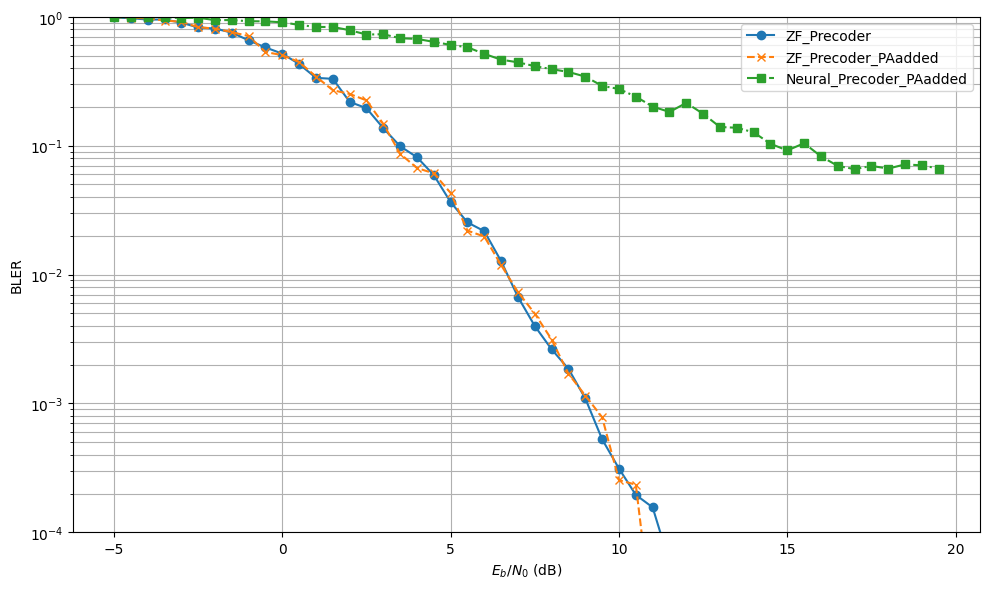

In [52]:
plt.figure(figsize=(10,6))
# Baseline - Perfect CSI
#not use PA and Precoder
plt.semilogy(ebno_dbs, BLER['ZF_Precoder'], 'o-', c=f'C0', label=f'ZF_Precoder')    
#use PA and not use Precoder
plt.semilogy(ebno_dbs, BLER['ZF_Precoder_PAadded'], 'x--', c=f'C1', label=f'ZF_Precoder_PAadded')
# Neural precoder
plt.semilogy(ebno_dbs, BLER['Neural_Precoder_PAadded'], 's-.', c=f'C2', label=f'Neural_Precoder_PAadded')
#
plt.xlabel(r"$E_b/N_0$ (dB)")
plt.ylabel("BLER")
plt.grid(which="both")
plt.ylim((1e-4, 1.0))
plt.legend()
plt.tight_layout()